In [ ]:
!pip install -U kaleido
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.io as pio
import os
import statsmodels.api as sm

from math import degrees

from google.colab import drive
drive.mount('/content/drive')

main_dataframe = pd.read_csv('/content/drive/My Drive/ISYE 3030 Project/FinalDataset.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Part III: Descriptive Stastiics**


---

In this part of the project, we will present the descriptive stastistics of the dataset, we will also use graphical methods to visualize the main components of the dataset.


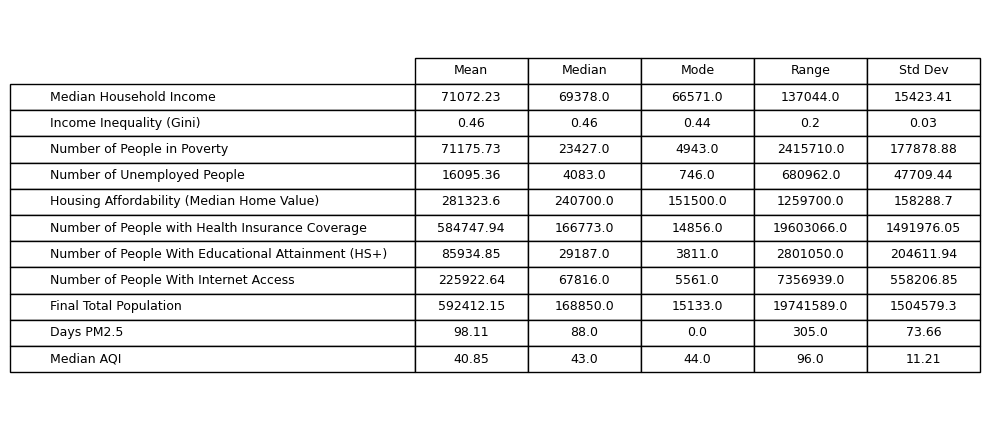

In [ ]:

numberofCBSAs = len(main_dataframe.index)
indicator_cols = ["Median Household Income", "Income Inequality (Gini)","Number of People in Poverty",
                   "Number of Unemployed People", "Housing Affordability (Median Home Value)",
                   "Number of People with Health Insurance Coverage", "Number of People With Educational Attainment (HS+)",
                   "Number of People With Internet Access", "Final Total Population","Days PM2.5", "Median AQI" ]
#Getting summary stastitics using scipy
summary_data = []
for col in indicator_cols:
    col_data = main_dataframe[col].dropna().values
    desc = stats.describe(col_data, ddof=1)
    mode_res = stats.mode(col_data, keepdims=True)

    stats_dict = {
        'Mean': desc.mean,
        'Median': np.median(col_data),
        'Mode': mode_res.mode[0] if mode_res.count[0] > 0 else np.nan,
        'Range': desc.minmax[1] - desc.minmax[0],
        'Std Dev': np.sqrt(desc.variance)
    }
    summary_data.append(stats_dict)

summary_df = pd.DataFrame(summary_data, index=indicator_cols).round(2)

# Plot as a table
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.4))
ax.axis('off')
tbl = ax.table(cellText=summary_df.values,
               colLabels=summary_df.columns,
               rowLabels=summary_df.index,
               loc='center',
               cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.3)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ISYE 3030 Project/Descriptive_stats.png")
plt.show()



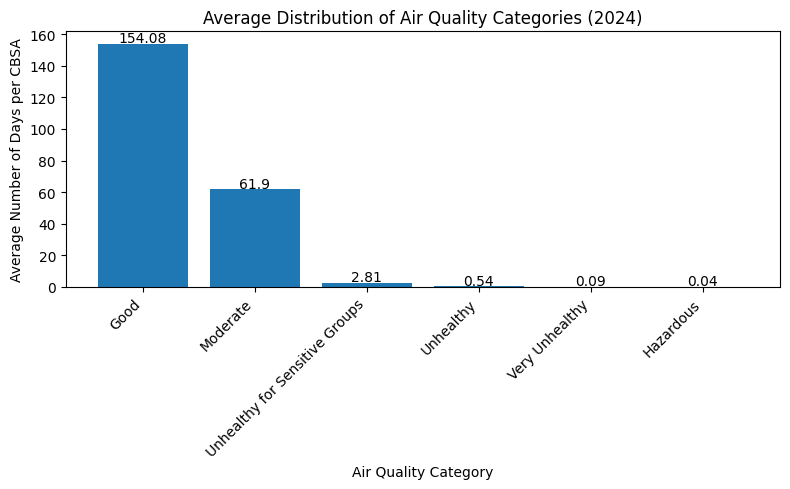

In [ ]:
#Frequency bin for the Air Quality Distribution
avg_counts = {
    'Good': main_dataframe['Good Days'].mean(),
    'Moderate': main_dataframe['Moderate Days'].mean(),
    'Unhealthy for Sensitive Groups':main_dataframe['Unhealthy for Sensitive Groups Days'].mean(),
    'Unhealthy': main_dataframe['Unhealthy Days'].mean(),
    'Very Unhealthy': main_dataframe['Very Unhealthy Days'].mean(),
    'Hazardous': main_dataframe['Hazardous Days'].mean()
}

#Prepare categories and values
categories = list(avg_counts.keys())
values = [round(avg_counts[cat], 2) for cat in categories]

#Plot bar chart with labels
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values)
plt.xlabel('Air Quality Category')
plt.ylabel('Average Number of Days per CBSA')
plt.title('Average Distribution of Air Quality Categories (2024)')
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(val), ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ISYE 3030 Project/Air_Quality_Distribution.png")
plt.show()

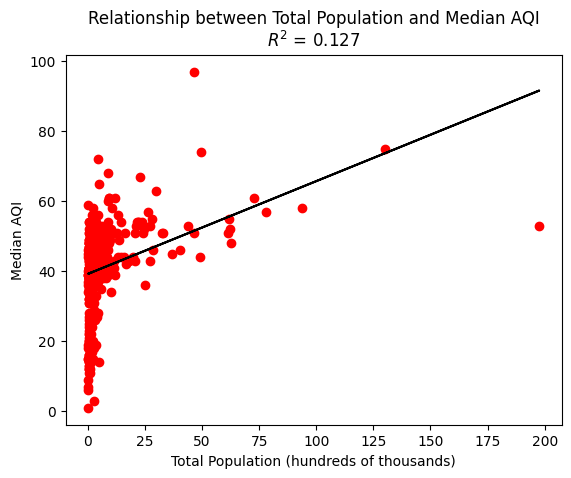

In [ ]:
#Scatter Plot
x = main_dataframe['Final Total Population'] / 100000
y = main_dataframe['Median AQI']
# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept
#Compute R^2
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot
#Plot
plt.figure()
plt.scatter(x, y, color = "red")
plt.plot(x, y_pred, color = "black")
plt.xlabel('Total Population (hundreds of thousands)')
plt.ylabel('Median AQI')
plt.title(f'Relationship between Total Population and Median AQI\n$R^2$ = {r2:.3f}')
plt.savefig("/content/drive/MyDrive/ISYE 3030 Project/Population_ScatterPlot.png")
plt.show()

In [ ]:
#Advance Visualization Chloropeth Map

#Creating Column for the States.
main_dataframe['State'] = main_dataframe['CBSA'].str.split(', ').str[-1]
df_states = main_dataframe[main_dataframe['State'].str.len() == 2]
# Aggregate by state (use 'Median AQI' or 'AQI' depending on what's available)
aqi_col = 'Median AQI' if 'Median AQI' in df_states.columns else 'AQI'
state_aqi = (
    df_states
    .groupby('State', as_index=False)[aqi_col]
    .mean()
)

# Build the choropleth map
fig = px.choropleth(
    state_aqi,
    locations='State',
    locationmode='USA-states',
    color=aqi_col,
    scope='usa',
    hover_name='State',
    color_continuous_scale=px.colors.sequential.YlOrRd,
    labels={aqi_col: f'{aqi_col}'},
    title=f'Average {aqi_col} by State'
)

#Apply Layout
fig.update_layout(
    template='plotly_white',
    title_x=0.5,
    margin=dict(l=0, r=0, t=50, b=0),
    paper_bgcolor='white',
    plot_bgcolor='white'
)
fig.update_geos(
    bgcolor='white',
    showlakes=True,
    lakecolor='white',
    showcountries=True,
    countrycolor='lightgray',
    showsubunits=True,
    subunitcolor='lightgray'
)
fig.show()


Part IV

In [ ]:


#Define high and low pollution based on 25th and 75th percentile of Median AQI
q25 = main_dataframe['Median AQI'].quantile(0.25)
q75 = main_dataframe['Median AQI'].quantile(0.75)

low_pollution = main_dataframe[main_dataframe['Median AQI'] <= q25]
high_pollution = main_dataframe[main_dataframe['Median AQI'] >= q75]

x1 = low_pollution['Median Household Income']
x2 = high_pollution['Median Household Income']

#Sample size
n1, n2 = len(x1), len(x2)

#Means
mean1, mean2 = x1.mean(), x2.mean()

#Standard deviations
s1, s2 = x1.std(ddof=1), x2.std(ddof=1)

#Welch-Satterthwaite degrees of freedom
df_welch = ((s1**2 / n1 + s2**2 / n2)**2) / ((s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1))

#t-statistic
t_stat = (mean1 - mean2) / np.sqrt(s1**2 / n1 + s2**2 / n2)

#Two-tailed critical t-value
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df_welch)

print("Welch’s Two-Sample t-Test (Critical Value Approach)")
print("----------------------------------------------------")
print(f"Test Statistic (t₀): {t_stat:.3f}")
print(f"Critical t-value (±t_crit): ±{t_critical:.3f}")
print(f"Degrees of Freedom: {df_welch:.3f}")
print(f"Mean Income (Low Pollution): ${mean1:.3f}")
print(f"Mean Income (High Pollution): ${mean2:.3f}")
print("----------------------------------------------------")
if abs(t_stat) > t_critical:
    print("Conclusion: Reject H₀ – There is a significant difference in means.")
else:
    print("Conclusion: Fail to reject H₀ – No significant difference in means.")


Welch’s Two-Sample t-Test (Critical Value Approach)
----------------------------------------------------
Test Statistic (t₀): -1.955
Critical t-value (±t_crit): ±1.969
Degrees of Freedom: 270.546
Mean Income (Low Pollution): $68942.169
Mean Income (High Pollution): $72605.664
----------------------------------------------------
Conclusion: Fail to reject H₀ – No significant difference in means.


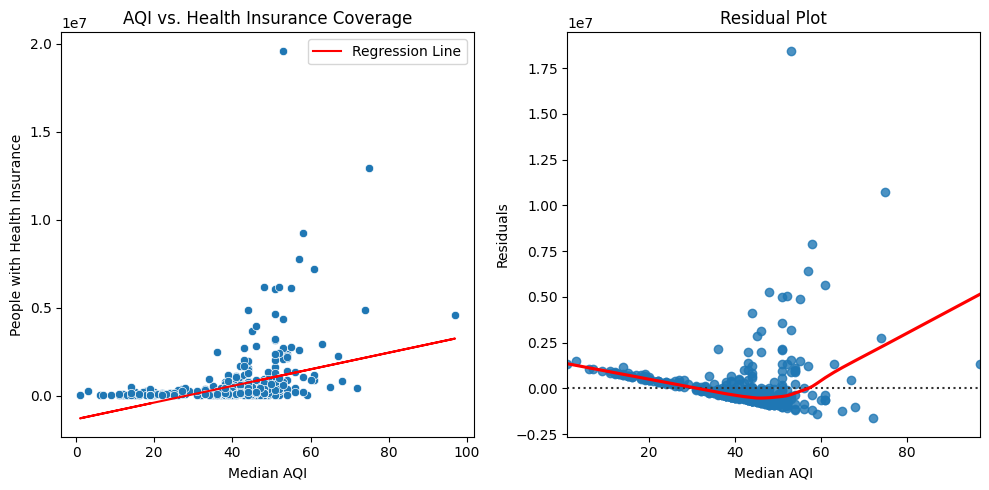

(None,
 np.float64(-1346769.495472488),
 np.float64(47279.69391410966),
 0.12612775863975956)

In [ ]:
#Perform regression: Median AQI vs Number of People with Health Insurance Coverage
x_col_hi = 'Median AQI'
y_col_hi = 'Number of People with Health Insurance Coverage'

#Clean and prepare data
df_hi = main_dataframe[[x_col_hi, y_col_hi]].dropna()
df_hi[x_col_hi] = pd.to_numeric(df_hi[x_col_hi], errors='coerce')
df_hi[y_col_hi] = pd.to_numeric(df_hi[y_col_hi], errors='coerce')
df_hi = df_hi.dropna()

#Fit regression model
X_hi = df_hi[[x_col_hi]]
y_hi = df_hi[y_col_hi]
model_hi = LinearRegression()
model_hi.fit(X_hi, y_hi)
df_hi['Predicted'] = model_hi.predict(X_hi)
df_hi['Residuals'] = y_hi - df_hi['Predicted']

# Extract model values
intercept_hi = model_hi.intercept_
slope_hi = model_hi.coef_[0]
r_squared_hi = r2_score(y_hi, df_hi['Predicted'])

#Generate plots
plt.figure(figsize=(10, 5))

#Scatterplot with regression line
plt.subplot(1, 2, 1)
sns.scatterplot(x=x_col_hi, y=y_col_hi, data=df_hi)
plt.plot(df_hi[x_col_hi], df_hi['Predicted'], color='red', label='Regression Line')
plt.xlabel('Median AQI')
plt.ylabel('People with Health Insurance')
plt.title('AQI vs. Health Insurance Coverage')
plt.legend()

#Residual plot
plt.subplot(1, 2, 2)
sns.residplot(x=df_hi[x_col_hi], y=df_hi[y_col_hi], lowess=True, line_kws={'color': 'red'})
plt.xlabel('Median AQI')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show(), intercept_hi, slope_hi, r_squared_hi


part vi

In [ ]:

predictors = [
    'Median AQI',
    'Number of Unemployed People',
    'Number of People With Educational Attainment (HS+)',
    'Number of People with Health Insurance Coverage',
    'Number of People With Internet Access',
    'Final Total Population'
]

#Clean data: drop rows with missing values
df_clean = main_dataframe[['Median Household Income'] + predictors].dropna()

#Define X and y
X = df_clean[predictors]
y = df_clean['Median Household Income']
X = sm.add_constant(X)

#Fit model
model = sm.OLS(y, X).fit()

#Summarize results
results_summary = {
    "R_squared": round(model.rsquared, 3),
    "Adjusted_R_squared": round(model.rsquared_adj, 3),
    "F_statistic": round(model.fvalue, 3),
    "model_p_value": round(model.f_pvalue, 3),
    "Coefficients": model.params.round(3).to_dict(),
    "P_values": model.pvalues.round(3).to_dict()
}

results_summary


{'R_squared': np.float64(0.234),
 'Adjusted_R_squared': np.float64(0.225),
 'F_statistic': np.float64(24.296),
 'model_p_value': np.float64(0.0),
 'Coefficients': {'const': 70323.486,
  'Median AQI': -47.234,
  'Number of Unemployed People': -0.422,
  'Number of People With Educational Attainment (HS+)': -0.135,
  'Number of People with Health Insurance Coverage': -0.095,
  'Number of People With Internet Access': 0.021,
  'Final Total Population': 0.121},
 'P_values': {'const': 0.0,
  'Median AQI': 0.443,
  'Number of Unemployed People': 0.0,
  'Number of People With Educational Attainment (HS+)': 0.0,
  'Number of People with Health Insurance Coverage': 0.243,
  'Number of People With Internet Access': 0.378,
  'Final Total Population': 0.132}}